### Universidad de Granada | ETSIIT


---
# **Práctica 3**: Redes Neuronales Convolucionales
---
**Asignatura:** Visión por Computador

**Autor:** Lugli, Valentino Glauco · YB0819879

## **Preámbulo**
### Añadiendo las librerías y funciones en común de los ejercicios necesarias para realizar la práctica.

In [1]:
# LIBRERÍAS

#   Usando Matplotlib para mostrar imágenes
import matplotlib.pyplot as plt
import matplotlib.colors as clr

#   Usando OpenCV para el resto de cosas con imágenes
import cv2 as cv

#   Usando Numpy para cálculos matriciales
import numpy as np

#   Usando Math para funciones matemáticas avanzadas
import math

#   Usando Random para obtener puntos
import random

#   Usando keras y tensorflow para las redes
import tensorflow as tf
import tensorflow.keras as k

import tensorflow.keras.utils as np_utils

from keras.models import Sequential

# Importar el conjunto de datos
from keras.datasets import cifar100

# Imports para hacer el conjunto de validación
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from keras.preprocessing.image import load_img,img_to_array

# Importando nombres de las capas por legibilidad

from keras.layers import Conv2D, Dense, MaxPooling2D, Flatten, BatchNormalization, Dropout, UpSampling2D

# Cosas para ResNet50
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

#########################################################################
######## FUNCIÓN PARA CARGAR Y MODIFICAR EL CONJUNTO DE DATOS ###########
#########################################################################

# A esta función sólo se le llama una vez. Devuelve 4 vectores conteniendo,
# por este orden, las imágenes de entrenamiento, las clases de las imágenes
# de entrenamiento, las imágenes del conjunto de test y las clases del
# conjunto de test.

def cargarImagenes():
  # Cargamos Cifar100. Cada imagen tiene tamaño (32, 32, 3).
  # Nos vamos a quedar con las imágenes de 25 de las clases.
  
  (x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='fine')
  x_train = x_train.astype('float32')
  x_test = x_test.astype('float32')
  x_train /= 255
  x_test /= 255
  
  train_idx = np.isin(y_train, np.arange(25))
  train_idx = np.reshape(train_idx,-1)
  x_train = x_train[train_idx]
  y_train = y_train[train_idx]
  
  test_idx = np.isin(y_test, np.arange(25))
  test_idx = np.reshape(test_idx, -1)
  x_test = x_test[test_idx]
  y_test = y_test[test_idx]
  
  # Transformamos los vectores de clases en matrices. Cada componente se convierte en un vector
  # de ceros con un uno en la componente correspondiente a la clase a la que pertenece la imagen.
  # Este paso es necesario para la clasificación multiclase en keras.
  y_train_v = np_utils.to_categorical(y_train, 25)
  y_test_v = np_utils.to_categorical(y_test, 25)
  
  return x_train, y_train_v, x_test, y_test_v


#########################################################################
######## FUNCIÓN PARA OBTENER EL ACCURACY DEL CONJUNTO DE TEST ##########
#########################################################################

# Esta función devuelve el accuracy de un modelo, definido como el 
# porcentaje de etiquetas bien predichas frente al total de etiquetas.
# Como parámetros es necesario pasarle el vector de etiquetas verdaderas
# y el vector de etiquetas predichas, en el formato de keras (matrices
# donde cada etiqueta ocupa una fila, con un 1 en la posición de la clase
# a la que pertenece y 0 en las demás).

def calcularAccuracy(labels, preds):
  labels = np.argmax(labels, axis = 1)
  preds = np.argmax(preds, axis = 1)
  
  accuracy = sum(labels == preds)/len(labels)
  
  return accuracy


#########################################################################
## FUNCIÓN PARA PINTAR LA PÉRDIDA Y EL ACCURACY EN TRAIN Y VALIDACIÓN ###
#########################################################################

# Esta función pinta dos gráficas, una con la evolución de la función
# de pérdida en el conjunto de train y en el de validación, y otra
# con la evolución del accuracy en el conjunto de train y en el de
# validación. Es necesario pasarle como parámetro el historial
# del entrenamiento del modelo (lo que devuelven las funciones
# fit() y fit_generator()).

def mostrarEvolucion(hist):

  loss = hist.history['loss']
  val_loss = hist.history['val_loss']
  plt.plot(loss)
  plt.plot(val_loss)
  plt.legend(['Training loss', 'Validation loss'])
  plt.show()

  acc = hist.history['accuracy']
  val_acc = hist.history['val_accuracy']
  plt.plot(acc)
  plt.plot(val_acc)
  plt.legend(['Training accuracy', 'Validation accuracy'])
  plt.show()


#########################################################################
################## FUNCIÓN PARA LEER LAS IMÁGENES #######################
#########################################################################

# Dado un fichero train.txt o test.txt y el path donde se encuentran los
# ficheros y las imágenes, esta función lee las imágenes
# especificadas en ese fichero y devuelve las imágenes en un vector y 
# sus clases en otro.

def leerImagenes(vec_imagenes, path):
  clases = np.array([img.split('/')[0] for img in vec_imagenes])
  imagenes = np.array([img_to_array(load_img(path + "/" + img, 
                                             target_size = (224, 224))) 
                       for img in vec_imagenes])
  return imagenes, clases


#########################################################################
############# FUNCIÓN PARA CARGAR EL CONJUNTO DE DATOS ##################
#########################################################################

# Usando la función anterior, y dado el path donde se encuentran las
# imágenes y los archivos "train.txt" y "test.txt", devuelve las 
# imágenes y las clases de train y test para usarlas con keras
# directamente.

def cargarDatos(path):
  # Cargamos los ficheros
  train_images = np.loadtxt(path + "/train.txt", dtype = str)
  test_images = np.loadtxt(path + "/test.txt", dtype = str)
  
  # Leemos las imágenes con la función anterior
  train, train_clases = leerImagenes(train_images, path)
  test, test_clases = leerImagenes(test_images, path)
  
  # Pasamos los vectores de las clases a matrices 
  # Para ello, primero pasamos las clases a números enteros
  clases_posibles = np.unique(np.copy(train_clases))
  for i in range(len(clases_posibles)):
    train_clases[train_clases == clases_posibles[i]] = i
    test_clases[test_clases == clases_posibles[i]] = i

  # Después, usamos la función to_categorical()
  train_clases = np_utils.to_categorical(train_clases, 200)
  test_clases = np_utils.to_categorical(test_clases, 200)
  
  # Barajar los datos
  train_perm = np.random.permutation(len(train))
  train = train[train_perm]
  train_clases = train_clases[train_perm]

  test_perm = np.random.permutation(len(test))
  test = test[test_perm]
  test_clases = test_clases[test_perm]
  
  return train, train_clases, test, test_clases

def compileModel(model):
    """
      Compilar un modelo dado unos parámetros por defecto.

    Parameters
    ----------
    model: Red neuronal

    Returns
    -------
    None

    """      
    # Compilando el modelo con función de pérdida de entropía cruzada categórica
    # con el optimizador Adam en parámetros por defecto y con la métrica de 
    # precisión a los datos.
    model.compile(loss = k.losses.categorical_crossentropy,
              optimizer = 'adam',
              metrics = ['accuracy'])
    

def getDataIterators(train_x, train_y, test_x, batches):
    """
      Generador de iteradores dados los datos de entrada, 
      no realiza aumento de datos pero se utiliza para
      poder utilizar la misma función que utiliza el fit.   

    Parameters
    ----------
    train_x : Lista de imagenes de entrenamiento
    train_y : Lista de etiquetas de entrenamiento
    test_x : Lista de imágenes de prueba
    batches: Numero de batches de entrenamiento.

    Returns
    -------
    it_train: Iterador de imágenes de entrenamiento.
    it_validation: Iterador de imágenes de validación.
    test_x: Imágenes de test ajustadas a los parámetros de entrenamiento.

    """  

    # Obtener iterador de IDG
    dataG = ImageDataGenerator()
    
    # Hacer el fit a los datos de entrenamiento.
    dataG.fit(train_x)
    
    # Realizar la división entre entrenamiento y validación con la función.
    X_train, X_val, Y_train, Y_val = train_test_split(train_x, train_y, test_size=0.1, stratify=train_y)
    
    # Obtener el iterador de entrenamiento.
    it_train = dataG.flow(X_train , Y_train, batch_size = batches)

    # Obtener el iterador de validación.
    it_validation = dataG.flow(X_val , Y_val)

    # Obtener el iterador de test.
    dataT = ImageDataGenerator()
    
    # Hacer fit con los datos de entrenamiento
    dataT.fit(train_x)

    # Estandarizar los datos de test con los de entrenamiento.
    dataT.standardize(test_x)

    return it_train, it_validation, test_x


def trainModel(model, train_x, val_x, batchSize, trainEpochs):
    """
    Entrenar una red convolucional

    Parameters
    ----------
    model: Modelo de Keras
      Modelo que se desea entrenar.

    train_x: Iterador de los datos de entrenamiento.
    
    val_x: Iterador de los datos de validación.

    batchSize: Tamaño del batch

    trainEpochs: Número de épocas en las que entrenar.

    Returns
    -------
    hist: Objeto que contiene el historial de entrenamiento de la red.

    """  
    # Se entrena la red.
    hist = model.fit(train_x, batch_size=batchSize, epochs=trainEpochs, 
                     validation_data = val_x, verbose=1)

    return hist

def getNormalizedData(trainImg, trainTag, batchSize, testImg):
    """
      Generador de iteradores dados los datos de entrada, 
      con aumento de datos.

    Parameters
    ----------
    train_x : Lista de imagenes de entrenamiento
    train_y : Lista de etiquetas de entrenamiento
    test_x : Lista de imágenes de prueba
    batches: Numero de batches de entrenamiento.

    Returns
    -------
    it_train: Iterador de imágenes de entrenamiento.
    it_validation: Iterador de imágenes de validación.
    test_x: Imágenes de test ajustadas a los parámetros de entrenamiento.

    """  
    # Aumento de datos, se añade: 
    # -Normalización estadística.
    # -Rotación hasta 10º
    # -Cambios de posición vertical y horizontal
    # -Voltear la imagen horizontalmente.
    dataG = ImageDataGenerator(featurewise_center = True,
                                 featurewise_std_normalization = True,
                                 rotation_range=10, 
                                 width_shift_range=0.2, 
                                 height_shift_range=0.2,
                                 horizontal_flip=True)
    
    # Hacer el fit a los datos de entrenamiento.
    dataG.fit(trainImg)

    # Realizar la división entre entrenamiento y validación con la función.
    X_train, X_val, Y_train, Y_val = train_test_split(trainImg, trainTag, test_size=0.1, stratify=trainTag)
    
    # Obtener el iterador de entrenamiento.
    it_train = dataG.flow(X_train , Y_train, batch_size = batchSize)

    # Obtener el iterador de validación.
    it_validation = dataG.flow(X_val , Y_val)

    # Obtener el iterador de test con la normalización.
    dataT = ImageDataGenerator(featurewise_center = True, featurewise_std_normalization = True)
    
    # Hacer fit con los datos de entrenamiento
    dataT.fit(trainImg)

    # Estandarizar los datos de test con los de entrenamiento.
    dataT.standardize(testImg)

    return it_train, it_validation, testImg

    
def testModel(model, text_x, test_y, hist):
    """
    Evalúa el modelo en el conjunto de datos de test

    Parameters
    ----------
    model: Modelo de Keras

    test_x: Lista de imágenes de test
    test_y: Lista de etiquetas de test
    hist: Objeto que contiene el historial de entrenamiento

    Returns
    -------
    None

    """  

    # Se muetra la gráfica de entrenamiento y validación.
    mostrarEvolucion(hist)
    print("Evaluando...")
    # Se evalúa e imprimen los datos de pérdida y precisión.
    score = model.evaluate(text_x, test_y, verbose=1)
    print("Resultados de Evaluación en Test\n - Loss:", score[0])
    print(' - Accuracy: ', score[1] * 100,"%")

---
##**Ejercicio 1** 


## Funciones auxiliares del Ejercicio 1

In [2]:
def getBaseNet():
    """
      Obtener un modelo de la red BaseNet


    Returns
    -------
    Objeto con el modelo de la red dentro.

    """

    # Definir model e incluir las capas en él
    model = Sequential(name="initialModel")
    
    #   1 - Conv2D
    #   2 - ReLU
    #           - 6 canales de salida
    #           - Tamaño de kernel 5
    #           - Entrada es una imagen 32x32x3 (RGB), se tiene que indicar
    #           cuando es la primera capa de la red según la documentación.
    #           - La salida tendrá dimensión 28 ya que el filtro no tiene padding.
    model.add(Conv2D(6, 5, activation='relu', input_shape = (32, 32, 3)))
    
    #   3 - MaxPooling2D
    #           - Kernel de 2x2, reduce la imagen a la mitad, de 28x28 a 14x14
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    #   4 - Conv2D
    #   5 - ReLU
    #           - 16 canales de salida
    #           - Tamaño de kernel 5
    #           - La salida tendrá dimensión 10 ya que el filtro no tiene padding.
    model.add(Conv2D(16, 5, activation="relu"))
    
    #   6 - MaxPooling2D
    #           - Kernel de 2x2, reduce la imagen a la mitad, de 10x10 a 5x5
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    #   Se aplasta con flatten, para conectarlo con las capas totalmente conectadas.
    model.add(Flatten())
    
    #   7 - Linear / Dense
    #   9 - ReLU
    #           - La dimensión de salida será de 50 unidades, que son 50 neuronas.
    model.add(Dense(50, activation='relu'))
    
    #   9 - Linear / Dense
    #           - Se tienen 25 neuronas, o sea que la salida será un vector de 25
    #           unidades.
    model.add(Dense(25, activation='softmax'))
    
    return model


## Implementación del Ejercicio 1

In [3]:
#%% EJERCICIO 1
###############

# Definidiendo constantes para el ejercicio
BATCH_SIZE = 64
EPOCHS = 50

# Obteniendo las imágenes dada la función proporcionada
train_x, train_y, test_x, test_y = cargarImagenes()

train_it, val_it, test_x = getDataIterators(train_x, train_y, test_x, BATCH_SIZE)

# Generando el modelo
baseNet = getBaseNet()

# Mostrando el modelo
baseNet.summary()

# Compilando el modelo
compileModel(baseNet)

169017344/169001437 [==============================] - 11s 0us/step
Model: "initialModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 6)         456       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 6)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 16)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 400)               0         
                                                    

In [4]:
# Entrenando el modelo
hist = trainModel(baseNet, train_it, val_it, BATCH_SIZE, EPOCHS)

Epoch 1/50
176/176 [==============================] - 15s 10ms/step - loss: 2.9010 - accuracy: 0.1591 - val_loss: 2.6481 - val_accuracy: 0.2280
Epoch 2/50
176/176 [==============================] - 1s 8ms/step - loss: 2.4716 - accuracy: 0.2828 - val_loss: 2.4296 - val_accuracy: 0.2872
Epoch 3/50
176/176 [==============================] - 1s 8ms/step - loss: 2.2923 - accuracy: 0.3412 - val_loss: 2.3316 - val_accuracy: 0.3224
Epoch 4/50
176/176 [==============================] - 1s 8ms/step - loss: 2.1804 - accuracy: 0.3660 - val_loss: 2.2321 - val_accuracy: 0.3616
Epoch 5/50
176/176 [==============================] - 1s 8ms/step - loss: 2.0839 - accuracy: 0.3947 - val_loss: 2.1829 - val_accuracy: 0.3696
Epoch 6/50
176/176 [==============================] - 1s 8ms/step - loss: 2.0092 - accuracy: 0.4149 - val_loss: 2.1557 - val_accuracy: 0.3632
Epoch 7/50
176/176 [==============================] - 1s 8ms/step - loss: 1.9509 - accuracy: 0.4250 - val_loss: 2.1272 - val_accuracy: 0.3648
Epoc

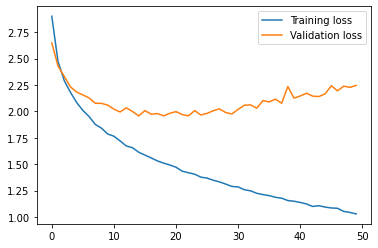

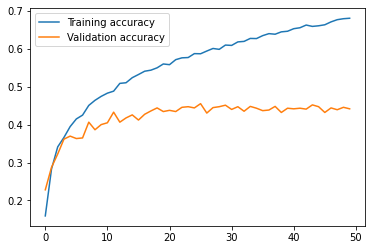

Evaluando...
79/79 [==============================] - 1s 5ms/step - loss: 2.1590 - accuracy: 0.4652
Resultados de Evaluación en Test
 - Loss: 2.159036874771118
 - Accuracy:  46.52000069618225 %


In [5]:
# Probando el modelo con test.
testModel(baseNet, test_x, test_y, hist)

---
##**Ejercicio 2** 



## Funciones auxiliares del Ejercicio 2


In [6]:
def getBaseNetPlusPlus(fix2, fix3, fix4):
    """
      Obtener un modelo de la red BaseNet

    Parameters
    ----------

    fix2: Booleano
      2º cambio de mejora en la red.

    fix3: Booleano
      3º cambio de mejora en la red.

    fix4: Booleano
      4º cambio de mejora en la red.


    Returns
    -------
    Objeto con el modelo de la red dentro.

    """
    # Definir model e incluir las capas en él
    model = Sequential(name="augmentedModel")
    
    if(fix3):
      model.add(Conv2D(128, 3, padding='same', activation='relu', input_shape = (32, 32, 3)))    
    else:
      model.add(Conv2D(6, 5, activation='relu', input_shape = (32, 32, 3)))

    if(fix2):
      model.add(BatchNormalization())                 
      model.add(Conv2D(128, 3, activation='relu'))
      model.add(BatchNormalization())               
    
    model.add(MaxPooling2D(pool_size=(2,2)))

    if(fix3):
      model.add(Conv2D(64, 5, activation="relu"))

    if(fix2):
      model.add(BatchNormalization())                 

    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Flatten())
    
    # 4º Cambio: Añadiendo profundidad a la red en redes densas + Dropout
    if(fix4):
      model.add(Dense(256, activation='relu'))
      model.add(Dropout(0.25))

      model.add(Dense(128, activation='relu'))
      model.add(Dropout(0.25))

      model.add(Dense(64, activation='relu'))
      model.add(Dropout(0.25))
    else:
      model.add(Dense(50, activation='relu'))

    model.add(Dense(25, activation='softmax'))

    return model

## Implementación del Ejercicio 2

In [7]:
#%% EJERCICIO 2
###############

# Definiendo que mejoras se aplican
fix1 = True
fix2 = True
fix3 = True
fix4 = True

# Definidiendo constantes para el ejercicio.
BATCH_SIZE = 64
EPOCHS = 50

# Obteniendo las imágenes dada la función proporcionada.
train_x, train_y, test_x, test_y = cargarImagenes()

# Primer cambio: Aumento de Datos
if(fix1):
  train_it, val_it, test_x = getNormalizedData(train_x, train_y, BATCH_SIZE, test_x)
else:
  train_it, val_it, test_x = getDataIterators(train_x, train_y, test_x, BATCH_SIZE)

# Obteniendo el modelo mejorado.
augmentedModel = getBaseNetPlusPlus(fix2, fix3, fix4)

# Mostrando el modelo
augmentedModel.summary()

# Compilando el modelo mejorado
compileModel(augmentedModel)

Model: "augmentedModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 32, 32, 128)       3584      
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 128)      512       
 ormalization)                                                   
                                                                 
 conv2d_3 (Conv2D)           (None, 30, 30, 128)       147584    
                                                                 
 batch_normalization_1 (Batc  (None, 30, 30, 128)      512       
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 15, 128)      0         
 2D)                                                             
                                                    

In [8]:
# Entrenando el modelo
hist = trainModel(augmentedModel, train_it, val_it, BATCH_SIZE, EPOCHS)

Epoch 1/50
176/176 [==============================] - 14s 70ms/step - loss: 3.0807 - accuracy: 0.1238 - val_loss: 3.3688 - val_accuracy: 0.0872
Epoch 2/50
176/176 [==============================] - 11s 62ms/step - loss: 2.8334 - accuracy: 0.1865 - val_loss: 2.7268 - val_accuracy: 0.2048
Epoch 3/50
176/176 [==============================] - 11s 60ms/step - loss: 2.6958 - accuracy: 0.2121 - val_loss: 2.4495 - val_accuracy: 0.3032
Epoch 4/50
176/176 [==============================] - 11s 61ms/step - loss: 2.5806 - accuracy: 0.2546 - val_loss: 2.3369 - val_accuracy: 0.3232
Epoch 5/50
176/176 [==============================] - 11s 62ms/step - loss: 2.4766 - accuracy: 0.2805 - val_loss: 2.2860 - val_accuracy: 0.3248
Epoch 6/50
176/176 [==============================] - 11s 63ms/step - loss: 2.3997 - accuracy: 0.3080 - val_loss: 2.1878 - val_accuracy: 0.3560
Epoch 7/50
176/176 [==============================] - 12s 65ms/step - loss: 2.3247 - accuracy: 0.3200 - val_loss: 2.1047 - val_accuracy:

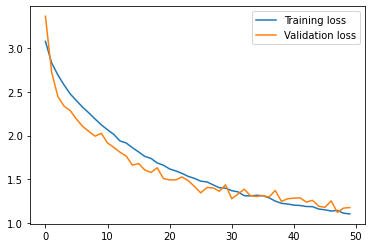

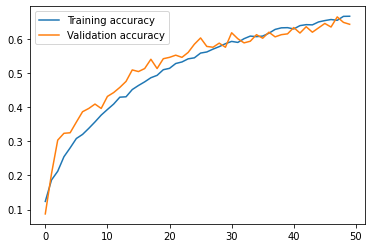

Evaluando...
79/79 [==============================] - 1s 11ms/step - loss: 1.1113 - accuracy: 0.6756
Resultados de Evaluación en Test
 - Loss: 1.111312747001648
 - Accuracy:  67.5599992275238 %


In [9]:
# Probando el modelo con test.
testModel(augmentedModel, test_x, test_y, hist)